## Regression

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [177]:
import tensorflow as tf
tf.reset_default_graph()

In [178]:
x_data = np.linspace(0.0, 10.0, 1000000)

In [179]:
noise = np.random.randn(len(x_data))

In [180]:
x_data

array([0.000000e+00, 1.000001e-05, 2.000002e-05, ..., 9.999980e+00,
       9.999990e+00, 1.000000e+01])

y = mx + b

b = 5

In [181]:
y_true = (0.5 * x_data) + 5 + noise

In [182]:
x_df = pd.DataFrame(data=x_data, columns=['X Data'])

In [183]:
y_df = pd.DataFrame(data=y_true, columns=['Y'])

In [184]:
x_df.head()

,X Data
0,0.00000
1,0.00001
2,0.00002
3,0.00003
4,0.00004


In [185]:
y_df.head()

,Y
0,4.253257
1,4.914648
2,5.227013
3,4.439460
4,4.151808


In [186]:
my_data = pd.concat([x_df, y_df], axis=1)

In [187]:
my_data.head()

,X Data,Y
0,0.00000,4.253257
1,0.00001,4.914648
2,0.00002,5.227013
3,0.00003,4.439460
4,0.00004,4.151808


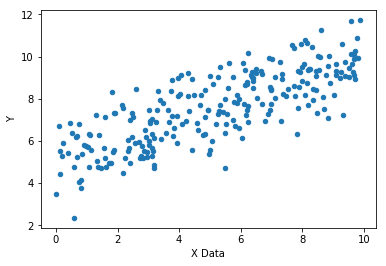

In [188]:
my_data.sample(n=250).plot(kind="scatter", x='X Data', y='Y')

In [189]:
batch_size = 8

In [190]:
np.random.randn(2)

array([-0.21955046, -1.31564551])

In [191]:
m = tf.Variable(name="m", initial_value=0.06, dtype=tf.float64)
b = tf.Variable(name="b", initial_value=-1.27, dtype=tf.float64)

In [192]:
# xph = tf.placeholder(tf.float64, [batch_size], name='xph')
xph = tf.placeholder(tf.float64, name='xph')

In [193]:
# yph = tf.placeholder(tf.float64, [batch_size], name='yph')
yph = tf.placeholder(tf.float64, name='yph')

In [194]:
y_model = tf.add(tf.multiply(m,xph), b, name='y')

In [195]:
error = tf.reduce_sum(tf.square(yph-y_model))

In [196]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)

In [197]:
train = optimizer.minimize(error)

In [198]:
init = tf.global_variables_initializer()

In [200]:
with tf.Session() as sess:
    sess.run(init)
    batches = 1000
    for i in range(batches):
        rand_ind = np.random.randint(len(x_data), size=batch_size)
        feed = {xph:x_data[rand_ind], yph:y_true[rand_ind]}
        sess.run(train, feed_dict = feed)
    model_m, model_b = sess.run([m, b])
    saver = tf.train.Saver()

with tf.Session(tf) as sess:
    
    x_tensor = sess.graph.get_tensor_by_name('xph:0')
    y_tensor = sess.graph.get_tensor_by_name('y:0')
    
    signature = tf.saved_model.signature_def_utils.build_signature_def(
        inputs={'xph': tf.saved_model.utils.build_tensor_info(x_tensor)},
        outputs={'y': tf.saved_model.utils.build_tensor_info(y_tensor)},
        method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME
    )
    
    builder = tf.saved_model.builder.SavedModelBuilder(export_dir)
    builder.add_meta_graph_and_variables(sess, [tag_constants.SERVING],
         signature_def_map={
        tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
            signature
    })
    builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tensorflow/saved_model/res/saved_model.pb


In [116]:
model_m

0.521275099059337

In [117]:
model_b

4.900720501250123

In [118]:
y_hat = x_data*model_m + model_b

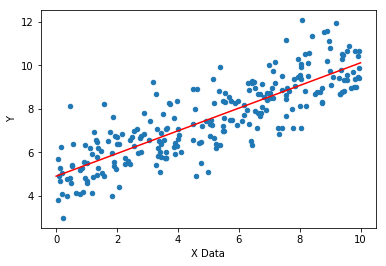

In [119]:
my_data.sample(250).plot(kind='scatter', x='X Data', y='Y')
plt.plot(x_data, y_hat, 'r')

In [124]:
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.saved_model import signature_constants

export_dir = "/tmp/tensorflow/saved_model/res"



with tf.Session(graph=tf.get_default_graph()) as sess:
    
    x_tensor = sess.graph.get_tensor_by_name('xph:0')
    y_tensor = sess.graph.get_tensor_by_name('yph:0')
    
    signature = tf.saved_model.signature_def_utils.build_signature_def(
        inputs={'xph': tf.saved_model.utils.build_tensor_info(x_tensor)},
        outputs={'yph': tf.saved_model.utils.build_tensor_info(y_tensor)},
        method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME
    )
    
    builder = tf.saved_model.builder.SavedModelBuilder(export_dir)
    builder.add_meta_graph_and_variables(sess, [tag_constants.SERVING],
         signature_def_map={
        tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
            signature
    })
    builder.save()


INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.


FailedPreconditionError: Attempting to use uninitialized value b
	 [[Node: save_5/SaveV2 = SaveV2[dtypes=[DT_DOUBLE, DT_DOUBLE, DT_DOUBLE, DT_DOUBLE, DT_DOUBLE, DT_DOUBLE, DT_DOUBLE, DT_DOUBLE], _device="/job:localhost/replica:0/task:0/device:CPU:0"](save_5/ShardedFilename, save_5/SaveV2/tensor_names, save_5/SaveV2/shape_and_slices, b, b_1, b_2, b_3, m, m_1, m_2, m_3)]]

Caused by op u'save_5/SaveV2', defined at:
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/tornado/ioloop.py", line 1073, in start
    handler_func(fd_obj, events)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-124-64b33904a2a7>", line 23, in <module>
    signature
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/tensorflow/python/saved_model/builder_impl.py", line 419, in add_meta_graph_and_variables
    saver = self._maybe_create_saver(saver)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/tensorflow/python/saved_model/builder_impl.py", line 282, in _maybe_create_saver
    allow_empty=True)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1281, in __init__
    self.build()
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1293, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1330, in _build
    build_save=build_save, build_restore=build_restore)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 769, in _build_internal
    save_tensor = self._AddShardedSaveOps(filename_tensor, per_device)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 360, in _AddShardedSaveOps
    return self._AddShardedSaveOpsForV2(filename_tensor, per_device)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 334, in _AddShardedSaveOpsForV2
    sharded_saves.append(self._AddSaveOps(sharded_filename, saveables))
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 275, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 193, in save_op
    tensors)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1687, in save_v2
    shape_and_slices=shape_and_slices, tensors=tensors, name=name)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/Users/fatu/venv/tensorflowpy2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value b
	 [[Node: save_5/SaveV2 = SaveV2[dtypes=[DT_DOUBLE, DT_DOUBLE, DT_DOUBLE, DT_DOUBLE, DT_DOUBLE, DT_DOUBLE, DT_DOUBLE, DT_DOUBLE], _device="/job:localhost/replica:0/task:0/device:CPU:0"](save_5/ShardedFilename, save_5/SaveV2/tensor_names, save_5/SaveV2/shape_and_slices, b, b_1, b_2, b_3, m, m_1, m_2, m_3)]]


## tf.estimator API

In [29]:
feat_col = [tf.feature_column.numeric_column('x', shape=[1])]

In [30]:
feat_col

[_NumericColumn(key='x', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [31]:
estimator = tf.estimator.LinearRegressor(feature_columns=feat_col)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/77/jl8t9nkx27q3q1536fj3b87h38zwgl/T/tmp03dv3m5a', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11f95e588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train Test Split


In [32]:
from sklearn.model_selection import train_test_split

In [33]:
x_train, x_eval, y_train, y_eval = train_test_split(x_data, y_true, test_size=0.3, random_state=101)

In [34]:
print(x_train.shape)
print(x_eval.shape)
print(y_train.shape)
print(y_eval.shape)

(700000,)
(300000,)
(700000,)
(300000,)


In [35]:
input_func = tf.estimator.inputs.numpy_input_fn({'x': x_train}, y_train, batch_size=8,
                                               num_epochs=None,shuffle=True)

In [36]:
train_input_func = tf.estimator.inputs.numpy_input_fn({'x': x_train}, y_train, batch_size=8,
                                               num_epochs=1000,shuffle=False)

In [37]:
eval_input_func = tf.estimator.inputs.numpy_input_fn({'x': x_eval}, y_eval, batch_size=8,
                                               num_epochs=1000,shuffle=False)

In [38]:
estimator.train(input_fn=input_func, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/77/jl8t9nkx27q3q1536fj3b87h38zwgl/T/tmp03dv3m5a/model.ckpt.
INFO:tensorflow:loss = 464.33713, step = 1
INFO:tensorflow:global_step/sec: 1059.67
INFO:tensorflow:loss = 11.662038, step = 101 (0.096 sec)
INFO:tensorflow:global_step/sec: 1523.62
INFO:tensorflow:loss = 7.060251, step = 201 (0.065 sec)
INFO:tensorflow:global_step/sec: 1447.24
INFO:tensorflow:loss = 15.587082, step = 301 (0.069 sec)
INFO:tensorflow:global_step/sec: 1632.76
INFO:tensorflow:loss = 13.01955, step = 401 (0.061 sec)
INFO:tensorflow:global_step/sec: 1421.99
INFO:tensorflow:loss = 13.395079, step = 501 (0.071 sec)
INFO:tensorflow:global_step/sec: 1332.53
INFO:tensorflow:loss = 7.2690606, step = 601 (0.074 sec)
INFO:tensorflow

In [39]:
train_metrics = estimator.evaluate(input_fn=train_input_func, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-09-23:22:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/77/jl8t9nkx27q3q1536fj3b87h38zwgl/T/tmp03dv3m5a/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2018-06-09-23:22:46
INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.0823207, global_step = 1000, loss = 8.6585655


In [47]:
eval_metrics = estimator.evaluate(input_fn=eval_input_func, steps=1000)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2018-06-09-23:23:23


INFO:tensorflow:Starting evaluation at 2018-06-09-23:23:23


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/77/jl8t9nkx27q3q1536fj3b87h38zwgl/T/tmp03dv3m5a/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/77/jl8t9nkx27q3q1536fj3b87h38zwgl/T/tmp03dv3m5a/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [100/1000]


INFO:tensorflow:Evaluation [100/1000]


INFO:tensorflow:Evaluation [200/1000]


INFO:tensorflow:Evaluation [200/1000]


INFO:tensorflow:Evaluation [300/1000]


INFO:tensorflow:Evaluation [300/1000]


INFO:tensorflow:Evaluation [400/1000]


INFO:tensorflow:Evaluation [400/1000]


INFO:tensorflow:Evaluation [500/1000]


INFO:tensorflow:Evaluation [500/1000]


INFO:tensorflow:Evaluation [600/1000]


INFO:tensorflow:Evaluation [600/1000]


INFO:tensorflow:Evaluation [700/1000]


INFO:tensorflow:Evaluation [700/1000]


INFO:tensorflow:Evaluation [800/1000]


INFO:tensorflow:Evaluation [800/1000]


INFO:tensorflow:Evaluation [900/1000]


INFO:tensorflow:Evaluation [900/1000]


INFO:tensorflow:Evaluation [1000/1000]


INFO:tensorflow:Evaluation [1000/1000]


INFO:tensorflow:Finished evaluation at 2018-06-09-23:23:24


INFO:tensorflow:Finished evaluation at 2018-06-09-23:23:24


INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.1052865, global_step = 1000, loss = 8.842292


INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.1052865, global_step = 1000, loss = 8.842292


In [41]:
print("training data metrics")
print(train_metrics)

training data metrics
{'average_loss': 1.0823207, 'loss': 8.6585655, 'global_step': 1000}


In [42]:
print("eval metrics")
print(eval_metrics)

eval metrics
{'average_loss': 1.1052865, 'loss': 8.842292, 'global_step': 1000}


In [43]:
brand_new_data = np.linspace(0, 10, 10)

In [44]:
input_fn_predict = tf.estimator.inputs.numpy_input_fn({'x': brand_new_data}, shuffle=False)

In [50]:
list(estimator.predict(input_fn=input_fn_predict))

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/77/jl8t9nkx27q3q1536fj3b87h38zwgl/T/tmp03dv3m5a/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/77/jl8t9nkx27q3q1536fj3b87h38zwgl/T/tmp03dv3m5a/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


[{'predictions': array([4.424999], dtype=float32)},
 {'predictions': array([5.0957537], dtype=float32)},
 {'predictions': array([5.766508], dtype=float32)},
 {'predictions': array([6.4372625], dtype=float32)},
 {'predictions': array([7.108017], dtype=float32)},
 {'predictions': array([7.778771], dtype=float32)},
 {'predictions': array([8.449526], dtype=float32)},
 {'predictions': array([9.120279], dtype=float32)},
 {'predictions': array([9.791035], dtype=float32)},
 {'predictions': array([10.461788], dtype=float32)}]

In [55]:
predictions = []# np.array([])
for x in estimator.predict(input_fn=input_fn_predict):
    predictions.append(x['predictions'])

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/77/jl8t9nkx27q3q1536fj3b87h38zwgl/T/tmp03dv3m5a/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/77/jl8t9nkx27q3q1536fj3b87h38zwgl/T/tmp03dv3m5a/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


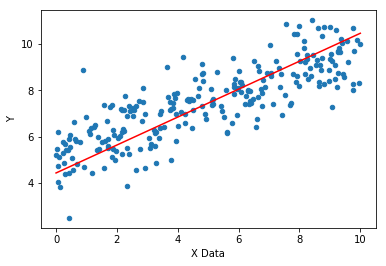

In [57]:
my_data.sample(250).plot(kind='scatter',x='X Data', y='Y')
plt.plot(brand_new_data, predictions,'r')